In [2]:
import scipy.io
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression , SGDClassifier
from sklearn.model_selection import validation_curve
from sklearn.metrics import  f1_score
from sklearn.metrics import accuracy_score
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.base import clone
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

## Loading the data

In [3]:
print(f'Data selection based on my student ID \
      {40101924%4}')

Data selection based on my student ID       0


In [4]:


# Normal dataset

!wget -q https://engineering.case.edu/sites/default/files/97.mat

# Faulty dataset

!wget -q https://engineering.case.edu/sites/default/files/105.mat


In [5]:

# Load .mat file
N_mat  = scipy.io.loadmat('97.mat')
F_mat = scipy.io.loadmat('105.mat')
info_N = scipy.io.whosmat('97.mat')
info_F = scipy.io.whosmat('105.mat')

print(info_N)
print(info_F)

# Extract the data

Normal_data = N_mat ['X097_DE_time']
Fault_data = F_mat ['X105_DE_time']

Normal_data.shape , Fault_data.shape
#checing if there is null data
N_df = pd.DataFrame(Normal_data)
F_df = pd.DataFrame(Fault_data)

print(N_df.isnull().sum())
print(F_df.isnull().sum())



[('X097_DE_time', (243938, 1), 'double'), ('X097_FE_time', (243938, 1), 'double'), ('X097RPM', (1, 1), 'double')]
[('X105_DE_time', (121265, 1), 'double'), ('X105_FE_time', (121265, 1), 'double'), ('X105_BA_time', (121265, 1), 'double'), ('X105RPM', (1, 1), 'double')]
0    0
dtype: int64
0    0
dtype: int64


## data extraction

In [6]:

# Extracting random M*N matrix
def extr(data, M, N):
    if len(data) < M * N:
        raise ValueError("The dataset does not have enough elements to form an MxN matrix.")

    # Shuffle the array
    np.random.shuffle(data)

    # Extract the first M*N elements and reshape them into an MxN matrix
    matrix = np.array(data[:M * N]).reshape(M, N)
    return matrix

M = 100
N = 200
Normal = extr(Normal_data,M,N)
Faulty = extr(Fault_data,M,N)
Normal.shape , Faulty.shape

((100, 200), (100, 200))

## feature extraction

In [31]:
import numpy as np
from scipy import stats

class FeatureExtraction:
    def __init__(self, matrix):
        self.matrix = matrix
        self.features = {
            'standard_deviation': self.standard_deviation(),
            'peak': self.peak(),
            'skewness': self.skewness(),
            'kurtosis' : self.kurtosis(),
            'crest_factor': self.crest_factor(),
            'clearance_factor' : self.clearance_factor(),
            'peak_to_peak' : self.peak_to_peak(),
            'shape_factor' : self.shape_factor(),
            'impact_factor': self.impact_factor(),
            'square_mean_root' : self.square_mean_root(),
            'mean': self.mean(),
            'absolute_mean': self.absolute_mean(),
            'root_mean_square': self.root_mean_square(),
            'impulse_factor' : self.impulse_factor()
        }

    def mean(self):
        return np.mean(self.matrix, axis=1)

    def absolute_mean(self):
        return np.mean(np.abs(self.matrix), axis=1)

    def standard_deviation(self):
        return np.std(self.matrix, axis=1)

    def peak(self):
        return np.max(self.matrix, axis=1)

    def skewness(self):
        return stats.skew(self.matrix, axis=1)

    def kurtosis(self):
        return stats.kurtosis(self.matrix, axis=1)

    def crest_factor(self):
        return self.peak() / self.root_mean_square()

    def clearance_factor(self):
        return self.peak() / np.square(self.square_mean_root())

    def peak_to_peak(self):
        return np.ptp(self.matrix, axis=1)

    def shape_factor(self):
        return self.root_mean_square() / self.absolute_mean()

    def impact_factor(self):
        return np.max(np.abs(self.matrix), axis=1) / self.absolute_mean()

    def square_mean_root(self):
        return np.square(np.mean(np.sqrt(np.abs(self.matrix)), axis=1))

    def root_mean_square(self):
        return np.sqrt(np.mean(np.square(self.matrix), axis=1))

    def impulse_factor(self):
        return np.max(np.abs(self.matrix), axis=1) / np.mean(np.abs(self.matrix), axis=1)




## Lableing

In [9]:

def process_datasets(normal_data, fault_data):

    normal_features = FeatureExtraction(normal_data).features
    fault_features = FeatureExtraction(fault_data).features

    # Convert dictionaries to arrays
    normal_features_array = np.array(list(normal_features.values())).T
    fault_features_array = np.array(list(fault_features.values())).T

    # Combine the features into a single dataset
    combined_features = np.concatenate((normal_features_array, fault_features_array), axis=0)

    # create labels, 0 for normal, 1 for fault
    labels = np.concatenate((np.zeros(normal_features_array.shape[0]), np.ones(fault_features_array.shape[0])))

    return combined_features, labels

# X is combined_features
# y is Lables
X, y = process_datasets(Normal, Faulty)
print("Combined Features Shape:", X.shape)
print("Labels:", y.shape)


Combined Features Shape: (200, 14)
Labels: (200,)


In [33]:
print(y)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]


## standardization & test train split

In [34]:
scaler = StandardScaler()
scaler.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X,y,
    test_size = 0.2,
    shuffle = True,
    random_state = 24
)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((160, 14), (40, 14), (160,), (40,))

##  Logistic Regression (from Scratch)

In [35]:
import numpy as np
import matplotlib.pyplot as plt

class LogisticRegression:
    def __init__(self, n_iter=100, lr=0.001, random_state=None):
        self.n_iter = n_iter
        self.eta = lr
        np.random.seed(random_state)
        self.loss = []

    def _weight_init(self, n_features):
        self.w = np.random.rand(n_features) * 0
        self.b = np.random.rand()

    def _update(self, x, E):
        dj = np.dot(x.T, E)
        self.w += self.eta * dj
        self.b += self.eta * np.sum(E)

    def forward(self, x):
        z = np.dot(x, self.w) + self.b
        a = 1 / (1 + np.e**(-z))
        y_hat = np.array([1 if hat > 0.5 else 0 for hat in a])
        return y_hat

    def error(self, predict, true):
        E = true - predict
        e = 1 / len(true) * np.dot(E, E)
        return E, e

    def train(self, x, y):
        n_features = x.shape[1]
        self._weight_init(n_features)
        for iter in range(self.n_iter):
            y_hat = self.forward(x)
            E, e = self.error(y_hat, y)
            self.loss.append(e)
            self._update(x, E)

    def predict(self, x):
        z = np.dot(x, self.w) + self.b
        a = 1 / (1 + np.exp(-z))
        y_pred = np.array([1 if pred > 0.5 else 0 for pred in a])
        return y_pred

    def plot_error(self):
        plt.plot(range(1, self.n_iter + 1), self.loss)
        plt.xlabel('Epoch')
        plt.ylabel('Error')
        plt.title('Error per Epoch')
        plt.show()



<ipython-input-35-7f4bdc7829b6>:22: RuntimeWarning: overflow encountered in power
  a = 1 / (1 + np.e**(-z))


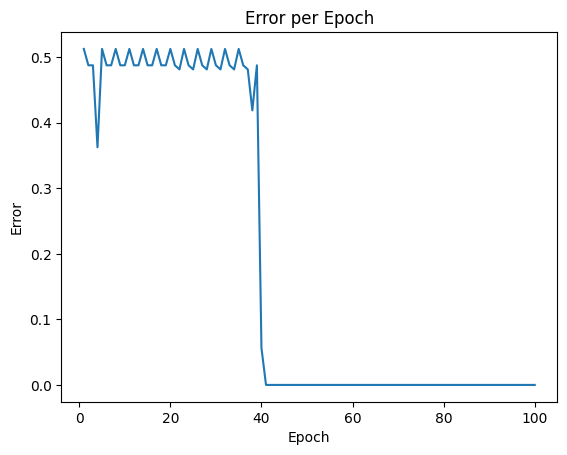

<ipython-input-35-7f4bdc7829b6>:42: RuntimeWarning: overflow encountered in exp
  a = 1 / (1 + np.exp(-z))


In [45]:

# Instantiate the LogisticRegression model
model = LogisticRegression(n_iter=100, lr=0.01, random_state=24)

# Train the model
model.train(x_train, y_train)

# Plot the training error
model.plot_error()

# Make predictions on test data
y_pred = model.predict(x_test)



#### Accuracy & Confusion matrix

In [47]:
def accuracy(y, y_hat):
    acc = np.sum(y == np.round(y_hat)) / len(y)
    return acc

def confusion_matrix(y, y_hat):
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0

    for a, p in zip(y, y_hat):
        if a == 1 and p == 1:
            true_positive += 1
        elif a == 0 and p == 0:
            true_negative += 1
        elif a == 0 and p == 1:
            false_positive += 1
        elif a == 1 and p == 0:
            false_negative += 1

    return true_negative, false_positive, false_negative, true_positive

from sklearn.metrics import  f1_score , confusion_matrix , accuracy_score


In [38]:
accuracy(y_test,y_pred),confusion_matrix(y_test,y_pred),f1_score(y_test,y_pred)

(1.0,
 array([[18,  0],
        [ 0, 22]]),
 1.0)

### SGD classifier

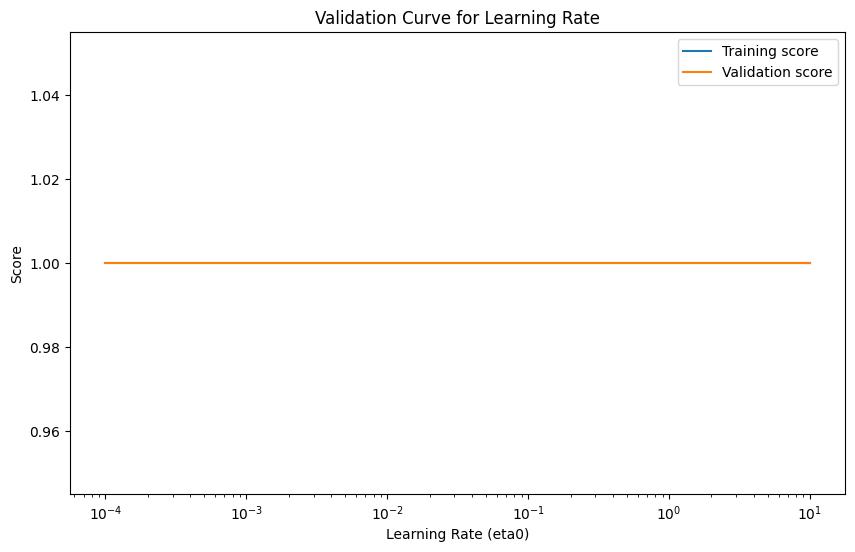

In [49]:
eta0_values = [0.0001, 0.001, 0.01, 0.1, 1, 10]
model2 = SGDClassifier(loss="log_loss"
                          , eta0=0.1
                          , learning_rate="constant"
                          , penalty=None
                          , random_state=24
                          , max_iter=100
                          )
model2.fit(x_train , y_train)
y2_pred = model2.predict(x_test) , y_test
train_scores, valid_scores = validation_curve(model2, x_train, y_train,
                                              param_name="eta0",
                                              param_range=eta0_values,
                                              scoring="accuracy"
                                              )

# Plot the validation curve
plt.figure(figsize=(10, 6))
plt.plot(eta0_values, np.mean(train_scores, axis=1), label='Training score')
plt.plot(eta0_values, np.mean(valid_scores, axis=1), label='Validation score')
plt.xscale('log')
plt.xlabel("Learning Rate (eta0)")
plt.ylabel("Score")
plt.title("Validation Curve for Learning Rate")
plt.legend()
plt.show()


In [58]:
#accuracy(y2_pred,y_test)
from sklearn.metrics import accuracy_score
model3 = SGDClassifier(loss="log_loss"
                          , eta0=0.01
                          , learning_rate="constant"
                          , random_state=24
                          , max_iter=100
                          )
model3.fit(x_train , y_train)
y3_pred = model3.predict(x_test)

accuracy_score(y3_pred,y_test) , f1_score(y3_pred,y_test)


(1.0, 1.0)